# Определение перспективного тарифа для телеком компании

### Ознакомление с данными

Откроем файлы с исходными данными.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Изучим общую информацию о исходных данных.

In [2]:
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Из таблицы с данными о пользователях из нашей выборки можем сделать вывод, что 38 человек из 500 (**7.6%**) меняли тарифный план в течение 2018 года. Для дальнейшей работы с данными нужно будет привести даты в таблице к типу *datetime*

In [3]:
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


В таблице с информацией о звонках бросаются в глаза нулевые значения. Ниже при подготовке данных рассмотрим эту ситуацию подробней. Кроме того, все значения, отличные от нуля округлим вверх до целых значений и приведем к целочисленному типу, так как тарификация оператора поминутная с округлением вверх. И, наконец, приведем даты в таблице к типу *datetime*

In [4]:
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


В датасете с информацией о сообщениях видим сами факты отправки сообщений. Можно сделать вывод, что каждая строка соответствует одному отправленному сообщению. Столбец с датами также требует приведения к *datetime*

In [5]:
internet.info()
internet.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
93877,93877,1317_184,99.18,2018-08-15,1317
83376,83376,1282_450,0.00,2018-03-08,1282
119729,119729,1403_284,376.02,2018-10-14,1403
69689,69689,1238_281,825.24,2018-12-29,1238
2873,2873,1010_3,831.59,2018-09-09,1010
55269,55269,1185_391,160.37,2018-08-12,1185
101184,101184,1339_163,672.85,2018-09-03,1339
39035,39035,1135_515,387.51,2018-02-28,1135
8733,8733,1030_202,443.43,2018-11-10,1030
30612,30612,1107_95,546.18,2018-10-16,1107


В таблице с данными о использованном абонентами интернет-трафике видим столбец без имени, в содержимом которого дублируются индексы строк. При подготовке данных удалим этот столбец. Кроме того предстоит объяснить появление нулевых значений в столбце *mb_used* и округлить ненулевые значения вверх в соответствии с тарифной политикой компании. И традиционно привести даты к *datetime*

In [6]:
tariffs.info()
tariffs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице с информацией о тарифах все идеально. Данные, с которыми можно работать без дополнительной обработки.

### Подготовка данных

**Пользователи**

Приведем данные в столбце *reg_date* к типу *datetime*

Далее выведем общую информацию о таблице, чтобы убедиться, что преобразование прошло корректно.

In [7]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


**Звонки**

Оценим количество звонков, длительность которых равна 0 минут.

In [8]:
len(calls[calls['duration'] == 0])

39613

Получаем 39613 строк, а это примерно каждый пятый звонок. Предположим, что здесь мы имеем дело с ситуацией, когда абонент не смог дозвониться до адресата. Набор номера имел место быть, в то время как длительность разговора равна нулю.

Такие ситуации не тарифицируются оператором "Мегалайн", поэтому можем удалить строки с нулевым временем разговора, так как другой полезной информации они не содержат.

In [9]:
calls = calls.query('duration > 0').reset_index(drop=True)

Приведем содержимое столбца *call_date* к типу данных *datetime*, затем добавим к таблице столбец *call_month*. В него запишем номер месяца, в который был совершен звонок.

In [10]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_month'] = calls['call_date'].dt.month

Далее округлим до ближайшего целого значения вверх длительность разговора и приведем содержимое столбца *duration* к целочисленному типу.

In [11]:
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

Посмотрим на общую информацию измененной таблицы, дабы убедиться, что все изменения прошли корректно:

In [12]:
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 5 columns):
id            162994 non-null object
call_date     162994 non-null datetime64[ns]
duration      162994 non-null int64
user_id       162994 non-null int64
call_month    162994 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id,call_month
0,1000_2,2018-06-11,3,1000,6
1,1000_3,2018-09-21,14,1000,9
2,1000_4,2018-12-15,6,1000,12
3,1000_7,2018-08-22,19,1000,8
4,1000_8,2018-09-15,19,1000,9
5,1000_10,2018-08-22,6,1000,8
6,1000_11,2018-05-28,19,1000,5
7,1000_12,2018-07-05,3,1000,7
8,1000_13,2018-09-29,8,1000,9
9,1000_14,2018-12-11,10,1000,12


**Сообщения**

Приведем информацию в столбце *message_date* к типу *datetime*, а затем добавим столбец *message_month*, в который сохраним номер месяца, в котором отправлено сообщение.

In [13]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_month'] = messages['message_date'].dt.month

Оценим корректность внесенных изменений:

In [14]:
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id               123036 non-null object
message_date     123036 non-null datetime64[ns]
user_id          123036 non-null int64
message_month    123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


**Интернет**

В первую очередь удалим столбец, в котором дублируются индексы таблицы.

Далее оценим количество строк, в которых количество потребленного трафика равно нулю.

In [15]:
internet = internet.drop(internet.columns[0], axis='columns')
len(internet[internet['mb_used'] == 0])

19598

Порядка **13%** всех записей таблицы имеют нулевые значения. В отличие от звонков, с интернет-трафиком нет лежащих на поверхности сценариев, когда соединение было установлено, но трафик не израсходован. Будем считать, что установка интернет-соединения по умолчанию влечет за собой расходование трафика из тарифного пакета. А поскольку все значения мегабайт у оператора "Мегалайн" округляются вверх, заменим нулевые значения единицами.

In [16]:
internet['mb_used'] = internet['mb_used'].replace(0, 1)

Далее, округлим все остальные значения столбца *mb_used* до целых значений вверх и приведем их к целочисленному типу.

In [17]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

Наконец, приведем значения столбца *session_date* к типу *datetime* и создадим новый столбец *session_month*, в котором будет храниться месяц установления интернет-соединения.

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_month'] = internet['session_date'].dt.month

Оценим визуально внесенные в таблицу изменения:

In [19]:
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id               149396 non-null object
mb_used          149396 non-null int64
session_date     149396 non-null datetime64[ns]
user_id          149396 non-null int64
session_month    149396 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id,session_month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9
5,1000_5,400,2018-10-02,1000,10
6,1000_6,541,2018-09-07,1000,9
7,1000_7,416,2018-07-11,1000,7
8,1000_8,506,2018-10-08,1000,10
9,1000_9,346,2018-09-03,1000,9


**Расчет дополнительных показателей**

Вычислим количество звонков и израсходованных минут абонентов по месяцам. Сохраним результаты в переменную *calls_stat*. Для улучшения читаемости полученной таблицы преобразуем индексы, полученные после группировки в столбцы.

In [20]:
calls_stat = calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['count', 'sum'])
calls_stat.reset_index(inplace=True)
calls_stat.columns = ['user_id', 'month', 'calls_count', 'calls_duration']
calls_stat.head(10)

,user_id,month,calls_count,calls_duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
5,1000,10,44,350
6,1000,11,37,338
7,1000,12,38,333
8,1001,11,45,430
9,1001,12,47,414


Вычислим количество сообщений абонентов по месяцам. Сохраним результаты в переменную *messages_stat*. Для улучшения читаемости полученной таблицы преобразуем индексы, полученные после группировки в столбцы.

In [21]:
messages_stat = messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc='count')
messages_stat.reset_index(inplace=True)
messages_stat.columns = ['user_id', 'month', 'messages_count']
messages_stat.head(10)

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


Вычислим количество израсходованных абонентами мегабайт трафика по месяцам. Сохраним результаты в переменную *internet_stat*. Для улучшения читаемости полученной таблицы преобразуем индексы, полученные после группировки в столбцы.

In [22]:
internet_stat = internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum')
internet_stat.reset_index(inplace=True)
internet_stat.columns = ['user_id', 'month', 'mb_used']
internet_stat.head(10)

,user_id,month,mb_used
0,1000,5,2257
1,1000,6,23262
2,1000,7,14017
3,1000,8,14072
4,1000,9,14583
5,1000,10,14717
6,1000,11,14769
7,1000,12,9829
8,1001,11,18460
9,1001,12,14059


Объединим данные с показателями звонков, сообщений и интернет-трафика по месяцам в переменную *all_stat*

In [23]:
all_stat = calls_stat.merge(messages_stat, how='outer')
all_stat = all_stat.merge(internet_stat, how='outer')
all_stat.head(10)

,user_id,month,calls_count,calls_duration,messages_count,mb_used
0,1000,5,17.0,159.0,22.0,2257.0
1,1000,6,28.0,172.0,60.0,23262.0
2,1000,7,41.0,340.0,75.0,14017.0
3,1000,8,42.0,408.0,81.0,14072.0
4,1000,9,46.0,466.0,57.0,14583.0
5,1000,10,44.0,350.0,73.0,14717.0
6,1000,11,37.0,338.0,58.0,14769.0
7,1000,12,38.0,333.0,70.0,9829.0
8,1001,11,45.0,430.0,NaN,18460.0
9,1001,12,47.0,414.0,NaN,14059.0


В объединенной таблице появились пропуски. Справедливо, ведь какие-то абоненты могут совсем не отправлять смс сообщений, другие не пользуются интернетом. А есть и категория пользователей, которые обходятся без звонков. Заполним пропущенные значения таблицы *all_stat* нулевыми.

In [24]:
all_stat.loc[all_stat['calls_count'].isna(), 'calls_count'] = 0
all_stat.loc[all_stat['calls_duration'].isna(), 'calls_duration'] = 0
all_stat.loc[all_stat['messages_count'].isna(), 'messages_count'] = 0
all_stat.loc[all_stat['mb_used'].isna(), 'mb_used'] = 0

In [25]:
all_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id           3214 non-null int64
month             3214 non-null int64
calls_count       3214 non-null float64
calls_duration    3214 non-null float64
messages_count    3214 non-null float64
mb_used           3214 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


От пропусков избавились, теперь, для увеличения информативности таблицы *all_stat* добавим столбец *tariff*, который будет сообщать нам, каким тарифным планом пользуется тот или иной абонент.

Для этого из таблицы *users* выделим тарифы в переменную *tariffs* и присоединим ее к датафрейму *all_stat*, предварительно вынеся *user_id* в индексы, чтобы воспользоваться методом *join*

In [26]:
all_stat.set_index('user_id', inplace=True)
users.set_index('user_id', inplace=True)
users_tariff = users['tariff']
all_stat = all_stat.join(users_tariff, lsuffix='user_id', rsuffix='user_id')

In [27]:
all_stat.sample(10)

,month,calls_count,calls_duration,messages_count,mb_used,tariff
user_id,,,,,,
1088,9,35.0,277.0,50.0,14682.0,smart
1006,5,45.0,370.0,0.0,12992.0,smart
1460,4,65.0,534.0,45.0,10792.0,smart
1179,6,59.0,440.0,0.0,15842.0,smart
1433,12,58.0,516.0,97.0,16501.0,smart
1424,10,5.0,29.0,106.0,29956.0,ultra
1138,10,65.0,562.0,9.0,26755.0,smart
1480,9,43.0,305.0,19.0,13661.0,smart
1018,8,103.0,929.0,20.0,8651.0,ultra


Далее, высчитаем помесячную выручку оператора с каждого пользователя. Результаты сохраним в столбце *revenue* таблицы *all_stat*

In [28]:
def month_revenue (row):
    calls = row['calls_duration']
    messages = row['messages_count']
    internet = row['mb_used']
    tariff = row['tariff']
    # для тарифа "смарт" вычисляем количество минут, сообщений и мегабайт сверх пакета для каждой строки
    if tariff == 'smart':
        extra_minutes = calls - tariffs.loc[0, 'minutes_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        extra_mbs = internet - tariffs.loc[0, 'mb_per_month_included']
    # если значения отрицательные - абонент вписался в тариф и экстра-платежей нет    
        if extra_minutes < 0:
            extra_minutes = 0
        if extra_messages < 0:
            extra_messages = 0
        if extra_mbs <0:
            extra_mbs = 0
     # возвращаем сумму обязательного платежа по тарифу и оплаты экстра-минут, сообщений и мегабайт       
        return(tariffs.loc[0, 'rub_monthly_fee'] + tariffs.loc[0, 'rub_per_minute'] * extra_minutes
              + tariffs.loc[0, 'rub_per_message'] * extra_messages + (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mbs
              )
    # аналогично для тарифа "ультра"
    else:
        extra_minutes = calls - tariffs.loc[1, 'minutes_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        extra_mbs = internet - tariffs.loc[1, 'mb_per_month_included']
        
        if extra_minutes < 0:
            extra_minutes = 0
        if extra_messages < 0:
            extra_messages = 0
        if extra_mbs <0:
            extra_mbs = 0
            
        return(tariffs.loc[1, 'rub_monthly_fee'] + tariffs.loc[1, 'rub_per_minute'] * extra_minutes
              + tariffs.loc[1, 'rub_per_message'] * extra_messages + (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mbs
              )
all_stat['revenue'] = all_stat.apply(month_revenue, axis=1)
all_stat.sample(20)

,month,calls_count,calls_duration,messages_count,mb_used,tariff,revenue
user_id,,,,,,,
1400,12,63.0,606.0,59.0,21774.0,smart,2147.734375
1337,5,17.0,170.0,10.0,18036.0,smart,1072.656250
1491,9,58.0,531.0,52.0,15134.0,ultra,1950.000000
1268,5,2.0,13.0,4.0,1742.0,smart,550.000000
1314,11,51.0,435.0,28.0,23532.0,smart,2146.093750
1004,9,18.0,117.0,146.0,15130.0,ultra,1950.000000
1196,5,16.0,164.0,24.0,3811.0,ultra,1950.000000
1224,11,54.0,425.0,0.0,21134.0,smart,1677.734375
1172,6,59.0,541.0,2.0,33932.0,smart,4300.343750


В исходных данных не сказано как рассчитывается трафик при превышении тарифного лимита. Будем считать, что в этой ситуации работают общие правила, когда списание средств со счета абонента происходит помегабайтно с округлением вверх. Соответственно плату за гигабайты превышения трафика будем списывать пропорционально потраченным пользователем мегабайтам.

На этапе подготовки данных была получена таблица *all_stat*, содержащая помесячные количество звонков, длительность звонков, количество сообщений, количество мегабайт трафика согласно тарификации оператора. Также в таблицу вошли данные о наименовании тарифа каждого абонента и ежемесячной выручки оператора.

### Анализ данных

Найдем среднее значение, дисперсию и стандартное отклонение для записей из таблицы *all_stat*. Будем рассматривать минуты звонков, сообщения и трафик для каждого тарифа. Результат сохраним в переменную *stat_indicators*

In [29]:
stat_indicators = all_stat.pivot_table(index='tariff', values=['calls_duration', 'messages_count', 'mb_used'],
                                      aggfunc=['mean', np.var, np.std])
stat_indicators

mean                                         var  \
       calls_duration       mb_used messages_count calls_duration   
tariff                                                              
smart      417.934948  16237.184388      33.384029   36219.315784   
ultra      526.623350  19488.703553      49.363452  100873.633397   

                                               std                \
             mb_used messages_count calls_duration       mb_used   
tariff                                                             
smart   3.457199e+07     796.812958     190.313730   5879.795158   
ultra   1.019516e+08    2285.266143     317.606098  10097.107541   

                       
       messages_count  
tariff                 
smart       28.227876  
ultra       47.804457

Построим гистограммы распределения значений для минут, сообщений и трафика. Сравним как отличаются показатели для разных тарифных планов. Предварительно разнесем данные по тарифам в переменные *ultra_stat* и *smart_stat*.

In [30]:
ultra_stat = all_stat.query('tariff == "ultra"')
smart_stat = all_stat.query('tariff == "smart"')

Оценим количество "абоненто-месяцев" для каждого тарифа. То есть посмотрим сколько месяцев, согласно нашей выборке суммарно пользовались каждым тарифом.

In [31]:
len(smart_stat)

2229

In [32]:
len(ultra_stat)

985

Месяцев использования тарифа "смарт" в **2,3 раза** больше, чем тарифа "ультра". Все-таки цена имеет значение!

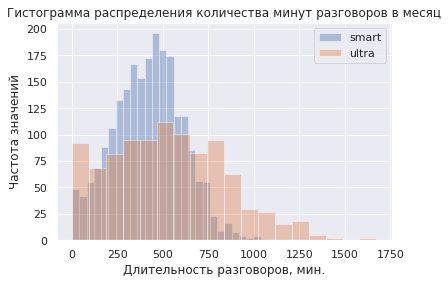

In [33]:
sns.set(style="darkgrid")
sns.distplot(smart_stat['calls_duration'], kde=False)
sns.distplot(ultra_stat['calls_duration'], kde=False)
plt.legend(['smart', 'ultra'])
plt.title('Гистограмма распределения количества минут разговоров в месяц')
plt.xlabel('Длительность разговоров, мин.')
plt.ylabel('Частота значений');

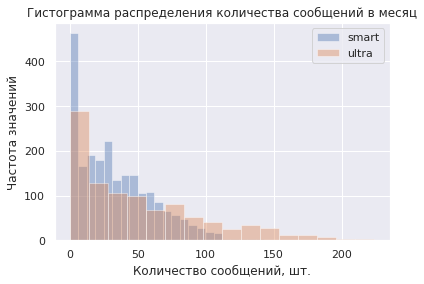

In [34]:
sns.distplot(smart_stat['messages_count'], kde=False)
sns.distplot(ultra_stat['messages_count'], kde=False)
plt.legend(['smart', 'ultra'])
plt.title('Гистограмма распределения количества сообщений в месяц')
plt.xlabel('Количество сообщений, шт.')
plt.ylabel('Частота значений');

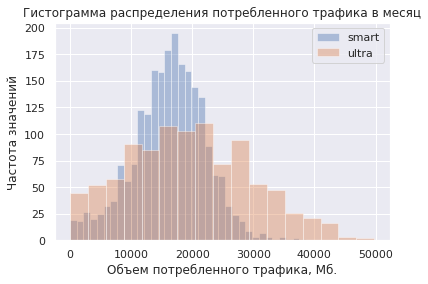

In [35]:
sns.distplot(smart_stat['mb_used'], kde=False)
sns.distplot(ultra_stat['mb_used'], kde=False)
plt.legend(['smart', 'ultra'])
plt.title('Гистограмма распределения потребленного трафика в месяц')
plt.xlabel('Объем потребленного трафика, Мб.')
plt.ylabel('Частота значений');

Кроме гистограмм посмотрим также на численные значения, воспользовавшись методом *desribe()* для каждой переменной.

In [36]:
smart_stat.describe()

,month,calls_count,calls_duration,messages_count,mb_used,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,8.346792,46.947510,417.934948,33.384029,16237.184388,1234.433893
std,2.920316,21.039171,190.313730,28.227876,5879.795158,788.368210
min,1.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,6.000000,32.000000,282.000000,10.000000,12662.000000,550.000000
50%,9.000000,47.000000,422.000000,28.000000,16540.000000,961.851562
75%,11.000000,61.000000,545.000000,51.000000,20078.000000,1669.000000
max,12.000000,162.000000,1435.000000,143.000000,38627.000000,6714.335938


In [37]:
ultra_stat.describe()

,month,calls_count,calls_duration,messages_count,mb_used,revenue
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,8.250761,59.236548,526.623350,49.363452,19488.703553,2060.591390
std,2.871762,35.562722,317.606098,47.804457,10097.107541,356.428319
min,1.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,6.000000,33.000000,284.000000,6.000000,11787.000000,1950.000000
50%,9.000000,58.000000,518.000000,38.000000,19324.000000,1950.000000
75%,11.000000,84.000000,752.000000,79.000000,26866.000000,1950.000000
max,12.000000,190.000000,1673.000000,224.000000,49793.000000,4743.896484


И для полноты картины построим диаграммы размаха, дабы сравнить данные по тарифам.

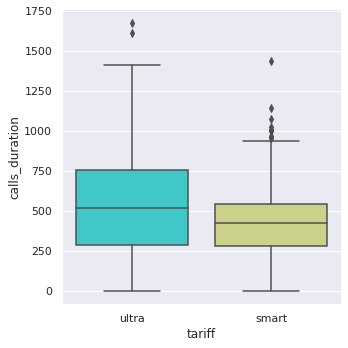

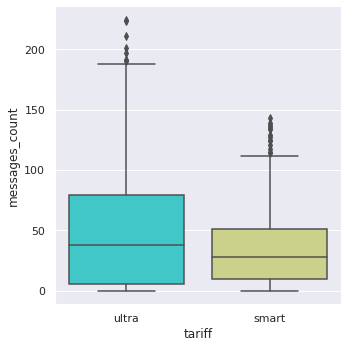

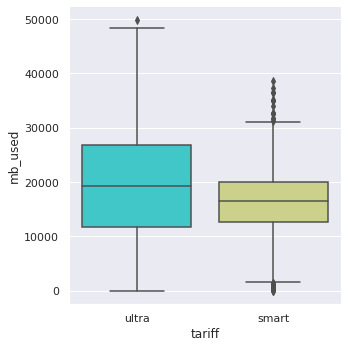

In [38]:
for column in ['calls_duration', 'messages_count', 'mb_used']:
    sns.catplot(x='tariff', y=column, kind="box", data=all_stat, palette='rainbow')

По результатам анализа данных о тарифах можно сделать следующие выводы:

**Дисперсия**

Значение дисперсии тарифа "Ультра" в разы превышает значения для тарифа "Смарт". Можно объяснить это куда большими количествами минут, сообщений и трафика, включенными в абонентскую плату.

**Распределение значений**

Распределение значений тарифа "Смарт", кроме значений отправленных сообщений, стремится к нормальному, с явно выраженной модой. Пиковые значения по частоте приходятся на ограничения по количеству минут и мегабайт, включенных в тариф.

Распределение значений тарифа "Ультра", кроме значений отправленных сообщений, лежит в довольно широких пределах, ярко выраженных пиков нет. Объясним это тем, что на вдвое меньшее количество "абоненто-месяцев" имеем куда более широкие интервалы возможных минут (**в 6 раз больше**) и гигабайт (**в 2 раза больше**) в отличие от тарифа "Смарт".

**Распределение значений отправленных сообщений**

В случае с сообщениями наблюдаем похожую картину для обоих тарифов. А именно, пик возле нуля и равномерное уменьшение частоты встречаемых значений с увеличением отправленных сообщений в месяц.

Это говорит нам о том, что эра SMS подходит к концу, абсолютное большинство абонентов оператора "Мегалайн" общается в мессенджерах. И даже на тарифе "ультра", в стоимость которого включено 1000 сообщений в месяц, максимальное количество для выборки составляет 224 SMS. В то время как 3 из 4 абонентов и вовсе укладываются в 79 сообщений.

**Выход за рамки тарифа и средняя прибыль**

Наблюдаем полярно противоположную картину по превышению лимитов для разных тарифов.

В случае с тарифом "Смарт" лишь каждый четвертый абонент укладывается в предоставленные оператором рамки. А средняя выручка одного месяца для "Мегалайна" составляет **1234 рубля**

Для абонентов "Ультры" же наиболее типичная картина, когда лимиты тарифа не достигнуты. Более 75% пользователей укладываются в предложенные оператором значения. Средняя же выручка одного месяца незначительно превышает условия тарифного плана и составляет **2060 рублей**

**Общие выводы**

Абонентам тарифа "Смарт" в среднем не хватает минут и трафика, включенных в тариф. Однако есть и ряд пользователей, которые расходуют ресурсы в рамках тарифа. Они дают пики на гистограмме распределения значений.

Абоненты тарифа "Ультра" за счет в разы превосходящего относительно "смарта" количества минут и трафика могут чувствовать себя более комфортно и не следить пристально за количеством оставшихся до конца месяца включенных в пакет минут и гигабайт.

SMS cообщения же в целом теряют свою популярность на фоне развития мессенджеров.

### Проверка гипотез

Проверим ряд гипотез.

**Гипотеза о равентсве средней выручки для пользователей разных тарифов**

*Нулевая гипотеза* будет звучать следующим образом:

Средняя выручка от пользователей тарифа "Смарт" равна средней выручке пользователей от тарифа "Ультра"

*Альтернативная гипотеза:*

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

*Уровень значимости* зададим в 5%.

Для параметра *equal_var* передадим значение *False*, так как ранее рассчитали дисперсию для пользователей разных тарифов и полученные значения существенно отличаются друг от друга

In [39]:
smart_revenue = smart_stat['revenue']
ultra_revenue = ultra_stat['revenue']

alpha = 0.05

results = st.ttest_ind(smart_revenue, ultra_revenue, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.532580812820177e-295
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Для того, чтобы лучше понять ситуацию, визуализируем показатели выручки для двух тарифов.

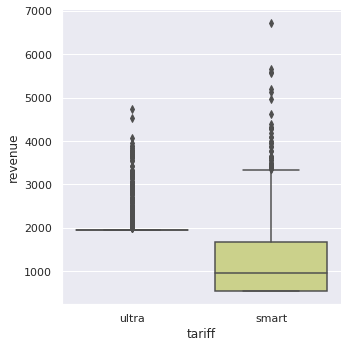

In [40]:
sns.catplot(x='tariff', y='revenue', kind="box", data=all_stat, palette='rainbow');

На диаграмме распределения отчетливо видно, что медианное значение для нашей выборки по тарифу "Ультра" превышает таковое по тарифу "Смарт" приблизительно в два раза.

По результатам же t-теста мы **с вероятностью более 99% можем сказать, что средние значения выручки от абонентов тарифов "Смарт" и "Ультра" различаются.**

**Гипотеза о равенстве средней выручки для абонентов из Москвы и из других регионов**

*Нулевая гипотеза:*

Средняя выручка от абонентов из Москвы равна средней выручке от абонентов из других регионов

*Альтернативная гипотеза:*

Средняя выручка от абонентов из Москвы и других регионов различаются

Уровень значимости зададим в 5%.

Перед проведением t-теста добавим в таблицу *all_stat* столбец *city*, в котором будет содержаться название городов, в которых проживают абоненты.

In [41]:
users_city = users['city']
all_stat = all_stat.join(users_city, lsuffix='user_id', rsuffix='user_id')

In [42]:
moscow_region = all_stat.query('city == "Москва"')
other_regions = all_stat.query('city != "Москва"')

In [43]:
moscow_region = moscow_region['revenue']
other_regions = other_regions['revenue']

alpha = 0.05

results = st.ttest_ind(moscow_region, other_regions)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.47591116736347616
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза устояла. Визуализируем распределение выручки для Москвы и других регионов для наглядности.

In [44]:
def region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
all_stat['region'] = all_stat['city'].apply(region)

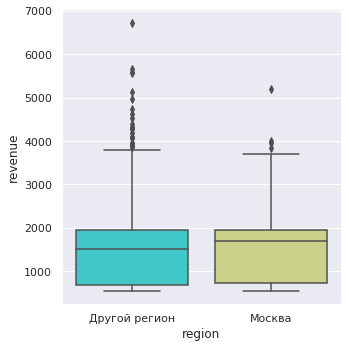

In [45]:
sns.catplot(x='region', y='revenue', kind="box", data=all_stat, palette='rainbow');

Действительно, на диаграмме распределения выручки от абонентов из Москвы и других регионов видим, что существенной разницы нет. Таким образом: **Средняя выручка от абонентов из Москвы равна средней выручке от абонентов из других регионов**

Если бы мы отвергли нулевую гипотезу о равенстве выручки, то ошиблись бы в 47,6% случаев.

### Общие выводы

По результатам анализа выборки из 500 абонентов можно сделать следующие выводы:
- абоненты тарифа "Смарт" как правило не укладываются в предложенные тарифом показатели и тратят на связь в среднем 1234 рубля при абонентской плате в 550 рублей;
- абоненты тарифа "Ультра" напротив в большинстве своем не пользуются услугами оператора сверх тарифных лимитов и тратят в среднем 2060 рублей при абонентской плате в 1950 рублей;
- нет зависимотсти от того, живет абонент в Москве или любом другом регионе, на связь в среднем он будет тратить сравнимые суммы.
- SMS-сообщения утрачивают популярность и оператор может предлагать большее количество в рамках пакетных предложений, абоненты ими скорей всего не воспользуются.Например, 3 из 4 пользователей тарифа "Ультра" с включенной 1000 сообщений отправляют в месяц не более 80.

И наконец ответ на главный вопрос заказчика. ***Какой же тариф приносит больше денег?***

Несмотря на то, что средняя месячная выручка от абонентов тарифа "Ультра" составляет 2060 рублей против 1234 рублей выручки от пользователя тарифа "Смарт" (**больше в 1,67 раза**), количество абонентов, подключенных к тарифу "Ультра" ощутимо больше. Для нашей выборки в 500 абонентов, распределенной по месяцам за 2018 год имеем 985 абонентов "Ультры" против 2229 абонентов  "Смарта"(**в 2,26 раза больше** для тарифа "Смарт").